In [1]:
import pandas as pd
import requests
import json
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
def get_GD_data(url):
  
  #buscando dados da API#######
  #Buscando com várias requisições
  df_aneel = pd.DataFrame()
  #dados = pd.DataFrame()
  
  offset = 0
  while True:
        url_base = url
        url_x = url_base + '&offset=' + str(offset)
        #fazendo o request da web page e retornando um objeto json
        response = requests.get(url_x).json()
        r = json.dumps(response)
        #converse a str json para py dict 
        loaded_r = json.loads(r)
        #print(loaded_r)
        total_data_rows = loaded_r['result']['total']
        #busca a tabela de dados desejada
        dados = json_normalize(loaded_r['result']['records'])
        #dados = pd.DataFrame(loaded_r['result']['records'])
        df_aneel = pd.concat([df_aneel, dados])
        offset += 32000
        #print(offset, total_data_rows)
        if offset >= total_data_rows:
          #print('estou dentro do if')

          break
        
  
  
  
  
  
  
  
  #filtra as colunas
  dados_aneel = df_aneel.loc[:, ['DatGeracaoConjuntoDados',
                              'SigAgente', 'DscClasseConsumo', 
                              'DscClasseConsumo', 'CodSubGrupoTarifario', 
                              'DscSubGrupoTarifario', 'SigUF', 'NomRegiao', 
                              'NomMunicipio', 'SigTipoConsumidor', 'NumCPFCNPJ',
                              'SigModalidadeEmpreendimento', 'SigTipoGeracao', 
                              'DscPorte', 'NumCoordNEmpreendimento', 'NumCoordEEmpreendimento',
                              'MdaPotenciaInstaladaKW','DthAtualizaCadastralEmpreend']]
  #buscas as linhas referentes a geração no RN
  #dados_aneel = dados_aneel.loc[dados_aneel.SigUF == 'RN', :]
  #remove linhas sem a informação da UF
  dados_aneel = dados_aneel.dropna(subset=['SigUF'])
  #filtra dados de apenas usinas fotovoltaicas 
  dados_aneel = dados_aneel.loc[dados_aneel.SigTipoGeracao == 'UFV', :]
  #cria novas colunas referentes ao mês e ano (pode ajudar na fase de visualização gráfica)
  #col_data = pd.DatetimeIndex(dados_aneel['DatGeracaoConjuntoDados'])
  col_data = pd.DatetimeIndex(dados_aneel['DthAtualizaCadastralEmpreend'])
  dados_aneel['Ano'] = col_data.year
  dados_aneel['Mes'] = col_data.month_name()
  #converte os valores objeto --> float
  dados_aneel['MdaPotenciaInstaladaKW'] = dados_aneel['MdaPotenciaInstaladaKW'].str.replace(',', '.').astype(float)

  #return dados_aneel.to_csv('/content/drive/MyDrive/Data_analsys/Dados_ANEEL.csv', index=False)
  return dados_aneel


In [3]:
url = 'https://dadosabertos.aneel.gov.br/api/3/action/datastore_search?resource_id=b1bd71e7-d0ad-4214-9053-cbd58e9564a7&q=RN&limit=32000'
data_GD = get_GD_data(url)

In [4]:
data_bar_plot = data_GD.loc[:,['NomRegiao', 'NumCoordNEmpreendimento', 'NumCoordEEmpreendimento', 
                        'MdaPotenciaInstaladaKW', 'Ano', 'Mes', 'DthAtualizaCadastralEmpreend'] ]

In [5]:
data_bar_plot['Ano'].unique()

array([2020, 2021, 2019, 2022, 2014, 2016, 2017, 2023, 2015, 2013, 2018])

In [6]:
data_GD['Mes'].unique()

array(['May', 'April', 'March', 'January', 'August', 'June', 'February',
       'September', 'July', 'October', 'November', 'December'],
      dtype=object)

In [7]:
list_1b = ['January', 'February']
data_bar_plot = data_GD.loc[((data_GD.Mes == list_1b[0]) | (data_GD.Mes == list_1b[1]))]

In [8]:
list_ano = data_bar_plot['Ano'].unique()

In [9]:
list_mes = data_bar_plot['Mes'].unique()

In [16]:
def bar_plot(df, list_year, list_mes):
    df_bar = df
    list_mes = list_mes
    list_year = list_year.sort()
    
    #modificando dados
    #df_bar = df_bar.rename(columns={'MdaPotenciaInstaladaKW' : 'Potência Instalada'})
    df_bar = df_bar.loc[:,['MdaPotenciaInstaladaKW', 'Ano', 'Mes'] ]
    df_bar = df_bar.groupby(['Ano','Mes'])['MdaPotenciaInstaladaKW'].sum()
    df_bar = df_bar.unstack(level='Mes')
    
    
    #desenha grafico
    fig = df_bar.plot.bar(figsize=(12,8)).figure
    plt.xlabel('Anos')
    plt.ylabel('Potência instalada UFV no 1° bimestre (kW)')
    plt.legend(title='Meses')
    
    #Salvar Figura
    fig.savefig('/content/drive/MyDrive/Data_analsys/bar_Pot_insta_1B.pdf')
    return fig

In [17]:
def bar_plot2(df, list_year, list_mes):
    df_bar = df
    list_mes = list_mes
    list_year = list_year.sort()
    
    #modificando dados
    #df_bar = df_bar.rename(columns={'MdaPotenciaInstaladaKW' : 'Potência Instalada'})
    df_bar = df_bar.loc[:,['MdaPotenciaInstaladaKW', 'Ano', 'Mes'] ]
    df_bar = df_bar.groupby(['Ano','Mes'])['MdaPotenciaInstaladaKW'].count()
    df_bar = df_bar.unstack(level='Mes')
    
    
    #desenha grafico
    fig = df_bar.plot.bar(figsize=(12,8)).figure
    plt.xlabel('Anos')
    plt.ylabel('Usinas cadastradas no 1° bimestre')
    plt.legend(title='Meses')
    
    #Salvar Figura
    fig.savefig('/content/drive/MyDrive/Data_analsys/bar_qtd_UFV_1B.pdf')
    return fig
    

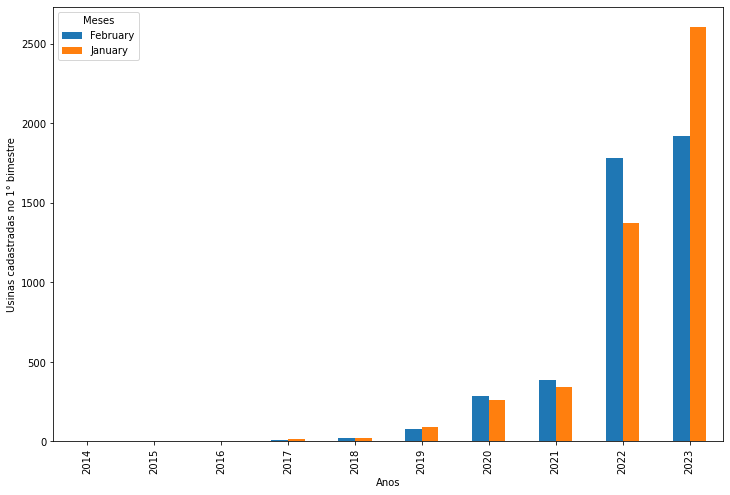

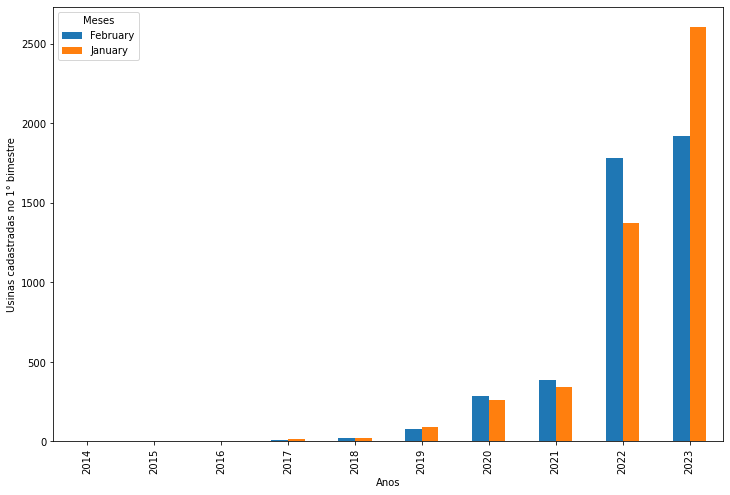

In [19]:
bar_plot2(data_bar_plot, list_ano, list_mes)

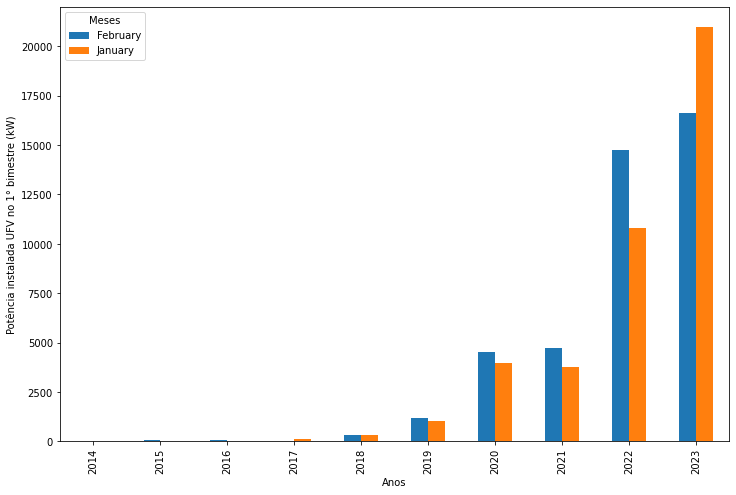

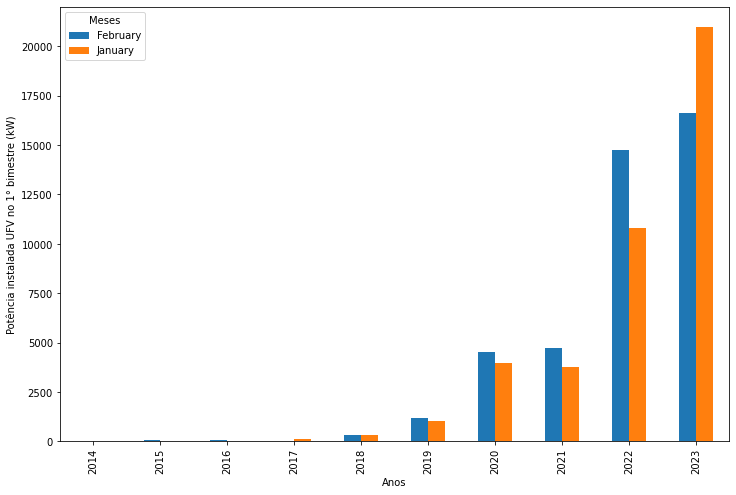

In [20]:
bar_plot(data_bar_plot, list_ano, list_mes)